In [6]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
df = pandas.read_csv('../hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)


## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}


d = 12

model_ss = pm.Model()

with model_ss:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    xi = pm.Bernoulli('xi', 0.8, shape=d)
    pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pnss,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    #trace = pm.sample(4000, tune=1000, cores=2, start=start,random_seed=0,step_kwargs={'nuts':{'target_accept':0.95}})

    real_ss_12param = pm.backends.load_trace('../real_ss_12param' + '.trace',model_ss)




logp = -91, ||grad|| = 505.17: 100%|██████████| 8/8 [00:00<00:00, 190.42it/s]
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Initialization
[[ 0.67745872 -0.08466578]
 [-0.09671527 -1.14033485]
 [-0.16558271  0.15817824]
 [-0.09951633  0.11087658]
 [-0.04709275  0.23517823]
 [-0.17829224  0.20845188]]


In [8]:
slab_df = 4
slab_scale = 2

model_rh = pm.Model()

d = 12

with model_rh:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.01)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=d)
    pn = pm.Deterministic('pn', z*tau*lt)
    #pn = pm.Normal('pn', mu=0, sigma=tau*l, shape=10)
    
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])


    #trace = pm.sample(1000, tune=500, cores=2, random_seed=0, target_accept=0.99)

    real_rh_12param = pm.backends.load_trace('../real_rh_12param' + '.trace',model_rh)




In [10]:
d = 12

model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Normal('pn', mu=0, sigma=1, shape=d)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    #trace = pm.sample(4000, tune=2000, cores=2, start=start,random_seed=0,target_accept=0.95)
    real_gauss = pm.backends.load_trace('../real_gauss_12param' + '.trace',model_sunode)

logp = -91.032, ||grad|| = 505.17: 100%|██████████| 8/8 [00:00<00:00, 513.32it/s]

Initialization
[[ 0.67745872 -0.08466578]
 [-0.09671527 -1.14033485]
 [-0.16558271  0.15817824]
 [-0.09951633  0.11087658]
 [-0.04709275  0.23517823]
 [-0.17829224  0.20845188]]



/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [19]:
pm.summary(real_gauss)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
pn[0],-1.153,0.354,-1.805,-0.860,0.239,0.199,2.0,2.0,3.0,24.0,2.39
pn[1],-2.840,1.331,-4.161,-1.147,0.933,0.793,2.0,2.0,3.0,14.0,1.98
pn[2],-0.935,1.106,-2.919,0.061,0.742,0.615,2.0,2.0,3.0,13.0,2.14
pn[3],-3.324,0.473,-4.226,-2.664,0.271,0.221,3.0,3.0,4.0,21.0,2.06
pn[4],-1.000,0.945,-2.061,-0.051,0.666,0.564,2.0,2.0,3.0,11.0,2.30
pn[5],-0.647,0.272,-0.908,-0.169,0.182,0.158,2.0,2.0,3.0,13.0,2.07
pn[6],0.650,0.248,0.413,1.038,0.171,0.143,2.0,2.0,2.0,13.0,2.34
pn[7],1.189,0.704,0.398,1.893,0.496,0.421,2.0,2.0,3.0,19.0,2.01
pn[8],0.428,0.698,-0.256,1.362,0.485,0.407,2.0,2.0,3.0,22.0,2.22
pn[9],1.059,0.091,0.872,1.247,0.039,0.029,5.0,5.0,5.0,17.0,1.80


In [11]:
# plot mean and intervals
with model_ss:
    ppc_ss = pm.sample_posterior_predictive(real_ss_12param,2000, var_names=['uobs','vobs','y0','pnss','sigma'], random_seed=2)

/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:07<00:00, 257.40it/s]


In [13]:
# plot mean and intervals
with model_rh:
    ppc_rh = pm.sample_posterior_predictive(real_rh_12param,2000, var_names=['uobs','vobs','y0','pn','sigma'], random_seed=2)

100%|██████████| 2000/2000 [00:09<00:00, 217.11it/s]


-0.00485958011602361
0.007702147655146457
-0.4182993178208272
-0.0002703833511845666
-0.0026876287530775977
0.01131087666277275
-0.006251513542719467
0.00445838132354115
0.5227575987474956
-0.7040288229198701
-0.006796408127881071
0.0027636724912109


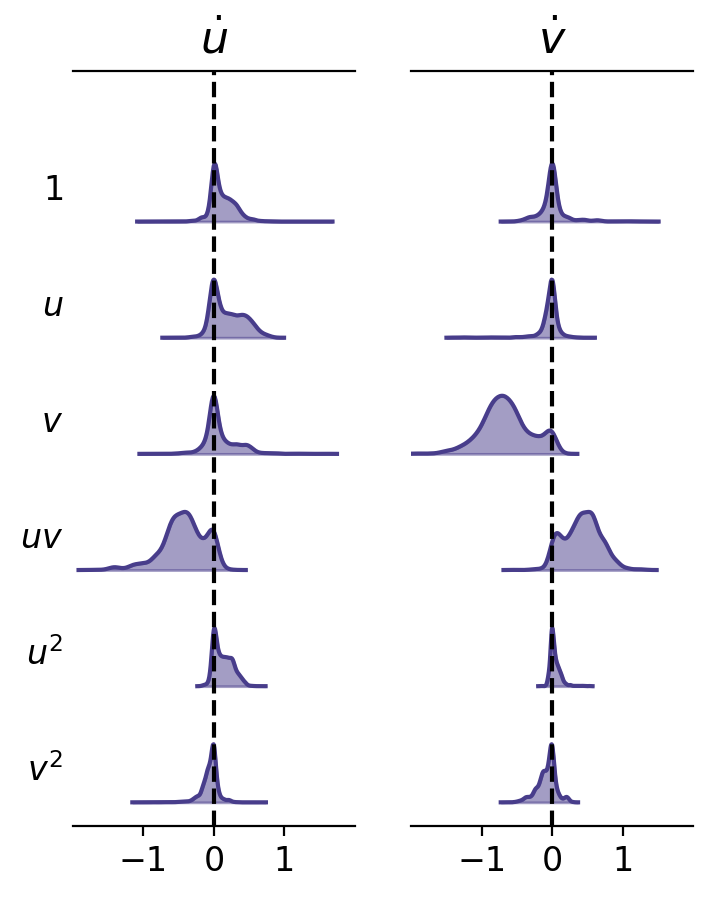

In [52]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_rh_12param['pn'].T[::2,:][[5,0,1,2,3,4],:][::-1], real_rh_12param['pn'].T[1::2,:][[5,0,1,2,3,4],:][::-1])


colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])
res_rh = []
        
        
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_rh.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([r'$1$',r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig5b.pdf')

-0.0025298069746874097
0.0023634637776785983
-0.5096812657392058
0.0030589797494713356
0.4731960210326165
-0.0007238570206479222
-0.0004048893400536713
0.0012744596094363264
0.5244850249878499
-0.7626535119253539
0.0014501888398918972
0.004007742386728963


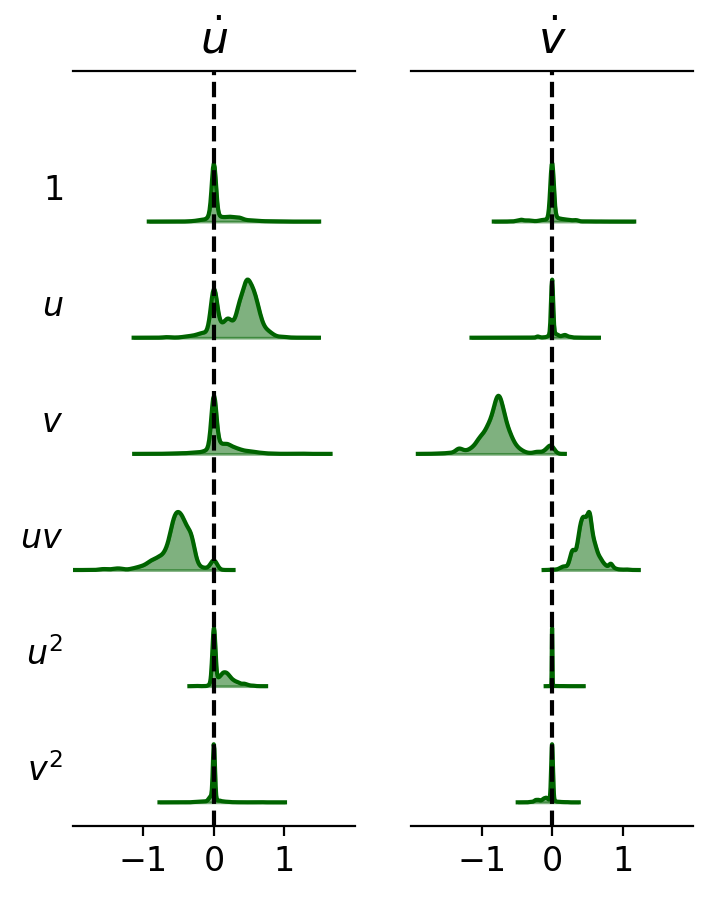

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_ss_12param['pnss'].T[::2,:][[5,0,1,2,3,4],:][::-1], real_ss_12param['pnss'].T[1::2,:][[5,0,1,2,3,4],:][::-1])


colors = ['darkgreen','darkgreen']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v + np.random.randn(*v.shape)*0.0002,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig5a.pdf')

0.6961358653229225
-0.864625499664389
0.04955359323664332
-0.05497663166069211
0.4134012143176672
-0.24844605993229096
3.8644331053381276
-4.158319614283108
-3.0203092332654426
-0.8948719029309946
1.8890604267621922
1.0269062020967803


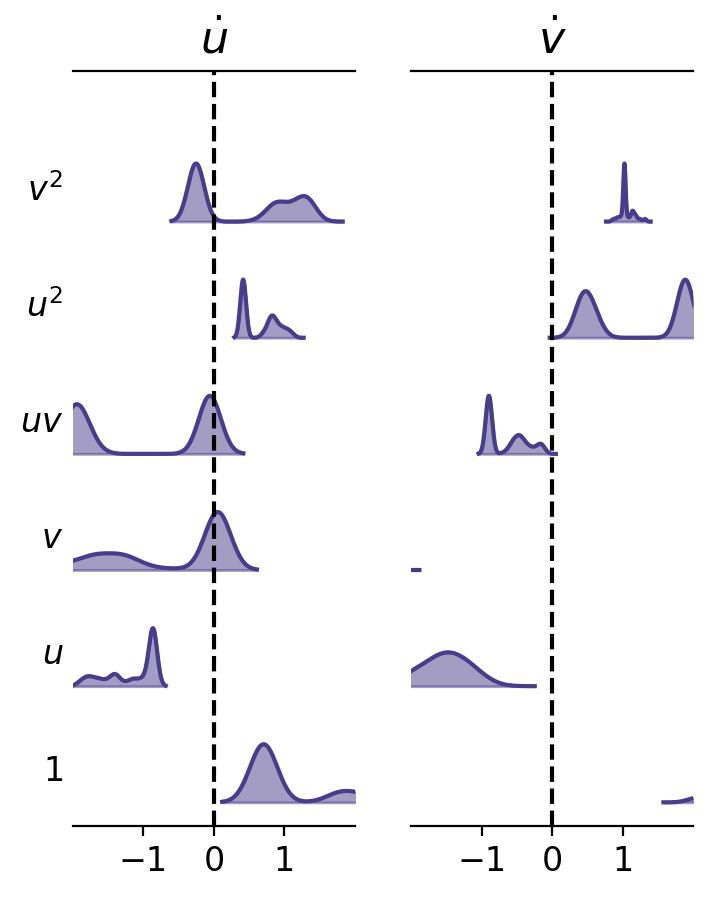

In [55]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_gauss['pn'].T[::2,:][[5,0,1,2,3,4],:], real_gauss['pn'].T[1::2,:][[5,0,1,2,3,4],:])


colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

res_gauss = []
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_gauss.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.show()

In [20]:
# Shrinkage coefficients regularized horseshoe
np.reshape(np.array(res_rh) / np.array(res_gauss),(6,2),order='F')[::-1,:]

array([[ 1.95599001e-02, -6.08771622e-03],
       [ 1.86311684e-02,  2.36010519e-03],
       [ 7.60867491e+00, -5.84170312e-01],
       [-5.45638234e-03,  2.33098259e-01],
       [ 3.10843105e-03,  1.63441216e-03],
       [ 1.62480878e-02,  7.15155992e-04]])

In [23]:
# Inclusion probablities spike and slab
np.reshape(real_ss_12param['xi'].mean(axis=0),(6,2))[[-1,0,1,2,3,4],:][::-1,:]

array([[0.31375 , 0.3545  ],
       [0.581   , 0.081875],
       [0.957875, 0.99975 ],
       [0.5375  , 0.993875],
       [0.845625, 0.341125],
       [0.468875, 0.35275 ]])

In [34]:
# Apply sindy to data
import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
#dx = sfd(inp)
data = yobs
dx = sfd(data)
optimizer = ps.STLSQ(threshold=0.015)
feature_library = ps.PolynomialLibrary(degree=2)
model = ps.SINDy(feature_names=["x", "y"],optimizer=optimizer,feature_library=feature_library)
model.fit(data, t=times)
sim = model.simulate(data[0], np.hstack((times)),hmin=1e-8)
model.print()

x' = 2.689 1 + 0.403 x + -0.207 y + -0.017 x y
y' = -3.650 1 + 0.144 x + -0.572 y + 0.015 x y


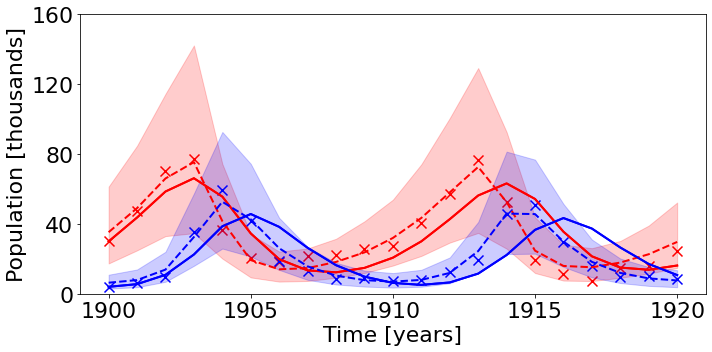

In [48]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T * yobs.std(axis=0)[i]
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 5,95
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2)
    
    plt.plot(times,sim[:, 0], "-", color='red',label="SINDy model", linewidth=2)
    plt.plot(times,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks([1900,1905,1910,1915,1920],fontsize=22)
    plt.ylim([0,160])
    plt.yticks([0,40,80,120,160],fontsize=22)
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population [thousands]',fontsize=22)
    plt.tight_layout()
    plt.savefig('fig5c.pdf')

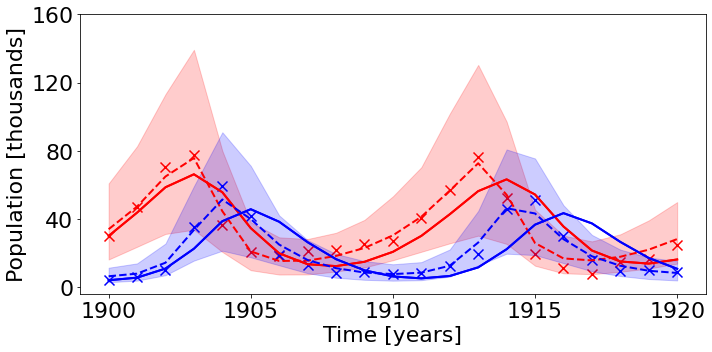

In [49]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_rh[name[i]].T * yobs.std(axis=0)[i]
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 5,95
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2)
    
    plt.plot(times,sim[:, 0], "-", color='red',label="SINDy model", linewidth=2)
    plt.plot(times,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks([1900,1905,1910,1915,1920],fontsize=22)
    plt.yticks([0,40,80,120,160],fontsize=22)
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population [thousands]',fontsize=22)
    plt.tight_layout()
    plt.savefig('fig5d.pdf')

-0.30444606905895655
-0.4267319311525255
0.2845948107380547
-0.9658430828387865
-0.539725779760516
0.2606647055884649
0.3019982447969445
0.17963481389098912
0.00979122758244344
0.09699446408184442
0.32072086161117497
0.5971108228018525
-0.30444606905895655
-0.4267319311525255
0.2845948107380547
-0.9658430828387865
-0.539725779760516
0.2606647055884649
0.3019982447969445
0.17963481389098912
0.00979122758244344
0.09699446408184442
0.32072086161117497
0.5971108228018525


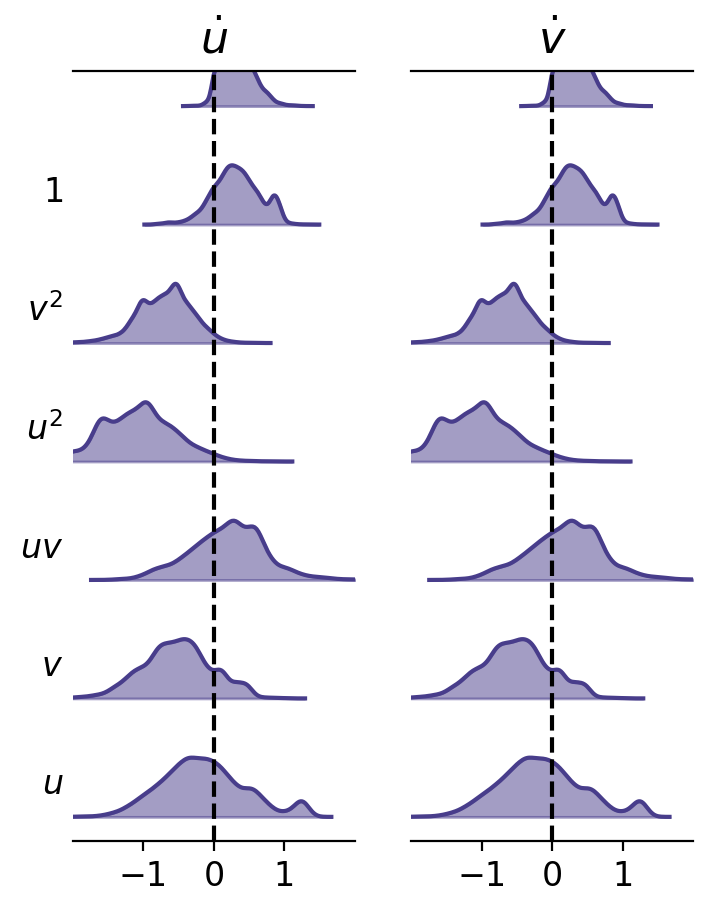

In [99]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_gauss['pn'].T, real_gauss['pn'].T)


colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

res_gauss = []
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_gauss.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                    r'$1$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)

-0.0026876287530775977
-0.006796408127881071
-0.0002703833511845666
-0.7040288229198701
-0.4182993178208272
0.5227575987474956
0.007702147655146457
0.00445838132354115
-0.00485958011602361
-0.006251513542719467
0.01131087666277275
0.0027636724912109
-0.0026876287530775977
-0.006796408127881071
-0.0002703833511845666
-0.7040288229198701
-0.4182993178208272
0.5227575987474956
0.007702147655146457
0.00445838132354115
-0.00485958011602361
-0.006251513542719467
0.01131087666277275
0.0027636724912109


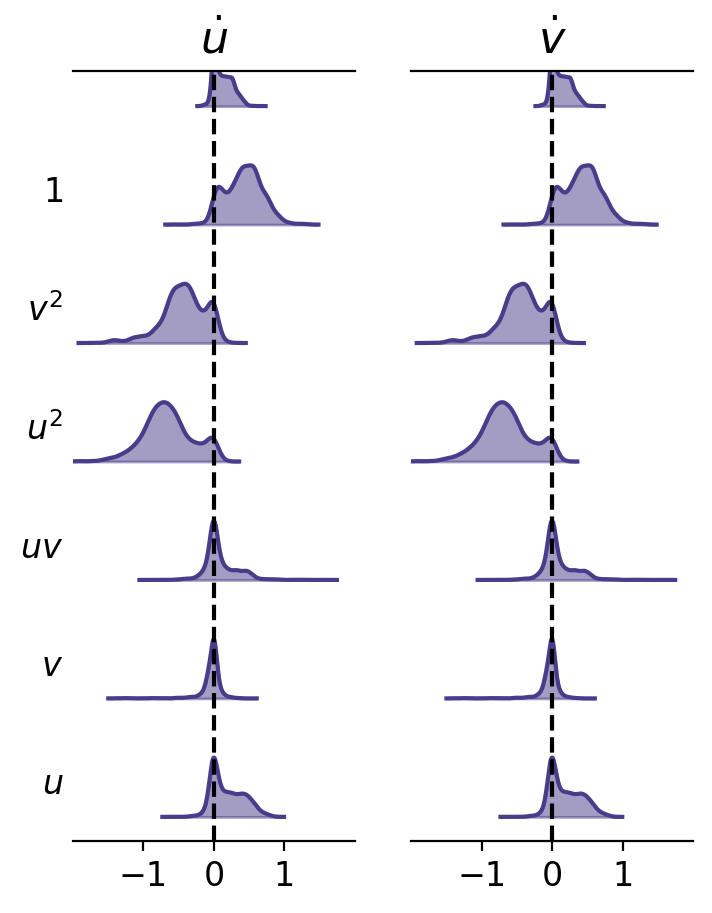

In [102]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (real_rh_12param['pn'].T, real_rh_12param['pn'].T)


colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])
res_rh = []
        
        
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_rh.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,6.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-1,0,1])
    ax[i].set_xlim([-2,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(6) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$u$', 
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                    r'$1$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig4b.pdf')

In [103]:
res_rh

[-0.0026876287530775977,
 -0.006796408127881071,
 -0.0002703833511845666,
 -0.7040288229198701,
 -0.4182993178208272,
 0.5227575987474956,
 0.007702147655146457,
 0.00445838132354115,
 -0.00485958011602361,
 -0.006251513542719467,
 0.01131087666277275,
 0.0027636724912109,
 -0.0026876287530775977,
 -0.006796408127881071,
 -0.0002703833511845666,
 -0.7040288229198701,
 -0.4182993178208272,
 0.5227575987474956,
 0.007702147655146457,
 0.00445838132354115,
 -0.00485958011602361,
 -0.006251513542719467,
 0.01131087666277275,
 0.0027636724912109]

In [105]:
np.array(res_rh)[:12] / np.array(res_gauss)[:12]

array([ 8.82793055e-03,  1.59266454e-02, -9.50064235e-04,  7.28926712e-01,
        7.75021934e-01,  2.00547902e+00,  2.55039484e-02,  2.48191385e-02,
       -4.96319800e-01, -6.44522716e-02,  3.52670438e-02,  4.62840797e-03])

In [107]:
np.array(res_rh)[:12] / np.array(res_gauss)[:12]

array([ 8.82793055e-03,  1.59266454e-02, -9.50064235e-04,  7.28926712e-01,
        7.75021934e-01,  2.00547902e+00,  2.55039484e-02,  2.48191385e-02,
       -4.96319800e-01, -6.44522716e-02,  3.52670438e-02,  4.62840797e-03])